In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import json

/Users/sinseongjin/tf110/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## 학습 데이터 파일 로드

In [2]:
FILE_DIR_PATH = './data/'
INPUT_TRAIN_DATA_FILE_NAME = 'input.npy'
LABEL_TRAIN_DATA_FILE_NAME = 'label.npy'
DATA_CONFIGS_FILE_NAME = 'data_configs.json'

In [3]:
input_data = np.load(open(FILE_DIR_PATH + INPUT_TRAIN_DATA_FILE_NAME, 'rb'))
label_data = np.load(open(FILE_DIR_PATH + LABEL_TRAIN_DATA_FILE_NAME, 'rb'))
prepro_configs = None

with open(FILE_DIR_PATH + DATA_CONFIGS_FILE_NAME, 'r') as f:
    prepro_configs = json.load(f)
    print(prepro_configs.keys())

dict_keys(['vocab', 'vocab_size'])


In [4]:
TEST_SPLIT = 0.1
RNG_SEED = 13371447

input_train, input_test, label_train, label_test = train_test_split(input_data, label_data, 
                                                                    test_size=TEST_SPLIT, random_state=RNG_SEED)

In [5]:
BATCH_SIZE = 16
NUM_EPOCHS = 10

def mapping_fn(X, Y):
    input, label = {'text': X}, Y
    return input, label

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((input_train, label_train))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(mapping_fn)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((input_test, label_test))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(mapping_fn)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

## 모델 정의

In [6]:
model_dir = './models/rnn_classifier'
vocab_size = prepro_configs['vocab_size']
embedding_size = 100
hidden_state_dim = 150
hidden_layer_dim = 150

learning_rate = 0.001


def model_fn(features, labels, mode, params):
    input_layer = tf.contrib.layers.embed_sequence(
                    features['text'],
                    vocab_size,
                    embedding_size)

    training = False
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        training = True
    
    input_layer = tf.layers.dropout(inputs=input_layer,
                                   rate=0.2,
                                   training=training)
    
    rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_state_dim, hidden_state_dim]]
    multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)

    outputs, state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                       inputs=input_layer,
                                       dtype=tf.float32)
    
    hidden = tf.layers.dense(inputs=outputs[:,-1,:], units=hidden_layer_dim, activation=tf.nn.tanh)

    hidden = tf.layers.dropout(inputs=hidden, rate=0.2, training=training)
    logits = tf.layers.dense(inputs=hidden, units=2)
    
#     logits = tf.squeeze(logits)
#     predicts = tf.nn.sigmoid(logits)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        # TFServing을 하기 위한 준비를 위해서는 output에 대한 export 정의를 해줄 필요가 있다.
        # 여기선 영화 평점 예측점수와 그 해당 영화 리뷰 텍스트에 대한 시멘틱 정보를 출력하고자 한다.
        softmax_logits = tf.nn.softmax(logits)
        
        predictions = {'sentiment': tf.argmax(softmax_logits, 1),
                       'confidence': tf.reduce_max(softmax_logits, axis=1)}
        
        # TFServing을 활용하여 예측값을 얻고자 한다면 예측 output에 대해서 프로토콜을 맞춰 export할 
        # 준비를 해야 한다. 이를 estimator.export.PredictOutput을 통해 해결 할 수 있다.
        export_outputs = {
          'prediction': tf.estimator.export.PredictOutput(predictions),
        }
        
        # TFServing 파일로 만들기 위해서는 export_outputs 파라메터를 반드시 지정해주어야 한다.
        # 이 파라메터가 없이 serving 모델에 대한 저장을 하려하면 이 파라메터에 대한 부재가 있음을
        # 에러를 통해 알게 될 것이다.
        return tf.estimator.EstimatorSpec(
                  mode=mode,
                  predictions=predictions,
                  export_outputs=export_outputs)
    
    one_hot_labels = tf.one_hot(labels, 2)
    loss = tf.losses.softmax_cross_entropy(one_hot_labels, logits)
#     loss = tf.losses.sigmoid_cross_entropy(labels, logits)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        accuracy = tf.metrics.accuracy(labels, tf.argmax(logits, 1))
        eval_metric_ops = {'acc': accuracy}

        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=eval_metric_ops)

    global_step = tf.train.get_global_step()
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step)

    return tf.estimator.EstimatorSpec(
              mode=mode,
              train_op=train_op,
              loss=loss)

In [7]:
est = tf.estimator.Estimator(model_fn=model_fn,
                             model_dir='checkpoint/train_model4')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'checkpoint/train_model4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0c0171e7b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
est.train(train_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into checkpoint/train_model4/model.ckpt.
INFO:tensorflow:loss = 0.69325185, step = 0
INFO:tensorflow:global_step/sec: 17.7991
INFO:tensorflow:loss = 0.6039523, step = 100 (5.619 sec)
INFO:tensorflow:global_step/sec: 18.7816
INFO:tensorflow:loss = 0.48150882, step = 200 (5.324 sec)
INFO:tensorflow:global_step/sec: 18.8831
INFO:tensorflow:loss = 0.43082845, step = 300 (5.296 sec)
INFO:tensorflow:global_step/sec: 18.8392
INFO:tensorflow:loss = 0.47063375, step = 400 (5.308 sec)
INFO:tensorflow:global_step/sec: 18.8304
INFO:tensorflow:loss = 0.69558847, step = 500 (5.311 sec)
INFO:tensorflow:global_step/sec: 18.8302
INFO:tensorflow:loss = 0.37839848, step = 600 (5.310 sec)
INFO:tensorflow:global_step/sec: 18.8267
INF

In [9]:
est.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-25-11:55:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from checkpoint/train_model4/model.ckpt-1407
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-25-11:55:20
INFO:tensorflow:Saving dict for global step 1407: acc = 0.8344, global_step = 1407, loss = 0.37572578
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1407: checkpoint/train_model4/model.ckpt-1407


{'acc': 0.8344, 'loss': 0.37572578, 'global_step': 1407}

## 캐글 평가 데이터셋 만들기

In [10]:
FILE_DIR_PATH = './data/'
INPUT_TEST_DATA_FILE_NAME = 'test_input.npy'

test_input_data = np.load(open(FILE_DIR_PATH + INPUT_TEST_DATA_FILE_NAME, 'rb'))

In [11]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"text":test_input_data}, shuffle=False)

In [12]:
predictions = np.array([p['sentiment'] for p in est.predict(input_fn=
predict_input_fn)])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from checkpoint/train_model4/model.ckpt-1407
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [13]:
tuple_predictions = np.array([(p['sentiment'], p['confidence']) for p in est.predict(input_fn=
predict_input_fn)])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from checkpoint/train_model4/model.ckpt-1407
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [28]:
pos, neg = list(), list()

for s, c in tuple_predictions:
    if s == 0:
        neg.append(c)
    else:
        pos.append(c)

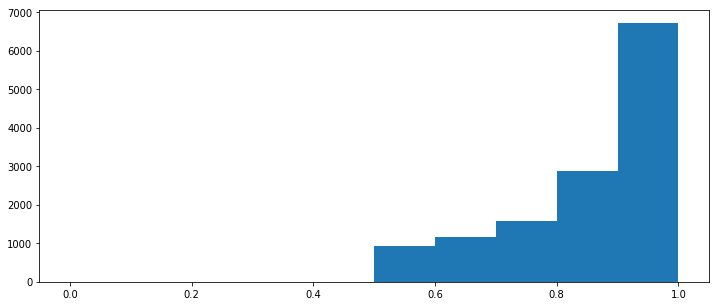

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(pos, range=[0,1])
plt.show()

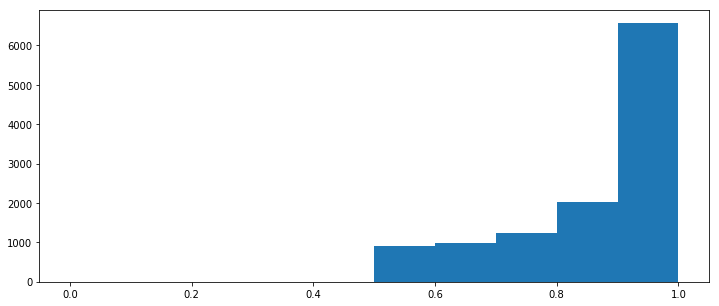

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(neg, range=[0,1])
plt.show()

In [14]:
DEFAULT_PATH='~/.kaggle/competitions/word2vec-nlp-tutorial/'

test = pd.read_csv(DEFAULT_PATH+"testData.tsv", header=0, delimiter="\t", quoting=3 )

In [15]:
test.head(10)

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."
5,"""2913_8""","""...as valuable as King Tut's tomb! (OK, maybe..."
6,"""4396_1""","""This has to be one of the biggest misfires ev..."
7,"""395_2""","""This is one of those movies I watched, and wo..."
8,"""10616_1""","""The worst movie i've seen in years (and i've ..."
9,"""9074_9""","""Five medical students (Kevin Bacon, David Lab..."


In [16]:
output = pd.DataFrame( data={"id":test["id"], "sentiment":list(predictions)} )
output.to_csv( "rnn_predict13.csv", index=False, quoting=3 )

## TFServing 파일로 저장하여 서비스 활용하기 예시

In [17]:
LIMIT_SEQ_LEN = 100

# Serving을 제공하기 위한 입력 리시버 함수를 선언해주어야 한다.
def serving_input_receiver_fn():
    # estimator에 입력하고자 하는 데이터를 dict 객체로 정의한다.
    receiver_tensor = {
        # 외부로부터 입력을 받는 프로토콜은 스트링이다. ServingInputReceiver 메뉴얼에도 언급되었다시피
        # 이 방식은 TFRecord 파일 형태로 시리얼화한 데이터 형태로 전송을 받는다. (이를 tf.example 방식이라고도 하는 것 같다)
        'text': tf.placeholder(dtype=tf.string, shape=[None])
    }
    
    # 다음은 TFRecord 방식으로 받은 데이터를 모델에 넣을 수 있게 처리를 하는 dict 객체라 보면 된다.
    # 쉽게 말하면 앞서 estimator를 진행하기 위해 data_fn의 과정을 작성해두는데 이 과정을 여기서 거친다 보면 된다.
    features = {
        key: tensor
        for key, tensor in receiver_tensor.items()
    }
    # TFRecord로 시리얼화 된 데이터를 integer tensor로 변환하기 위해서는 string to int로 decode를 해줘야 한다.
    fn = lambda query: tf.decode_raw(query, tf.int64)
    features['text'] = tf.map_fn(fn, features['text'], dtype=tf.int64)
    # 받은 데이터에 대해 모델입력에 맞는 shape로 구성을 해주기 위해 reshape을 해준다.
    features['text'] = tf.reshape(features['text'], [-1, LIMIT_SEQ_LEN])

    # 위에 정의한 받을 데이터에 대한 프로토콜과 모델에 입력할 데이터 전처리를 다음 함수 파라메터에 입력해준다.
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensor)

In [18]:
export_dir_base = './served_model/new_staging'

# 서빙에 대한 입력 리시버함수와 저장 위치를 파라메터로 지정한다면, 서빙 pb파일로 저장하여 간단하게 모델을 활용할 수 있게 된다.
# 실행을 하게 되면 저장된 파일의 위치를 텍스트 출력을 통해 얻게된다.
path = est.export_savedmodel(export_dir_base, serving_input_receiver_fn) #,
#                       strip_default_attrs=True)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['prediction', 'serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from checkpoint/train_model4/model.ckpt-1407
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./served_model/new_staging/temp-b'1537876528'/saved_model.pb


In [19]:
# 모델이 저장된 경로 위치를 파라메터로 지정하여 함수를 부르면 간단하게 예측 모델을 활용할 수 있다.
# 이 모델 예측을 간단하게 함수로 받게된다.
predictor_fn = tf.contrib.predictor.from_saved_model(
    export_dir = path,
    # 옵션이지만 실행되는 모델에 대한 이름을 명시하고자 한다면 다음의 파라메터를 활용한다.
    signature_def_key="serving_default"
)

INFO:tensorflow:Restoring parameters from ./served_model/new_staging/1537876528/variables/variables


In [20]:
# 입력 데이터는 array 형태로 입력을 할 수가 있다. 이 때 주의할 점은 데이터 타입을 
# 반드시 입력 리시버 함수에서 정의한 데이터 타입과 일치시켜야한다.
# 보통 int32, int64 데이터에 대한 정의가 맞지않아 막상 데이터를 모델에 입력했을 때 
# 바이너리 데이터 길이의 불일치 문제로 이어져 에러가 발생할 수 있다.

d = np.array(input_data[0], dtype=np.int64)
print('입력 데이터 array: ', d)

d = d.tostring()
print('\n모델에 입력하기 위한 array: ', d)

입력 데이터 array:  [   89    77    45    23    92   772   242     7   125   347     2   199
   122     3  7572   729     2  3581  8961    12 37400  2004     8    10
    17     6     3   236   465  1579     6   364    29     4     1    89
   999    77   123     5  1625    10  1132    18     6    24  2473    71
    16    30     1   676     9   137   509    10   849  7066    71     9
    88    20   121    85    77    50    28   270   485  4535  3530     9
   121    10    15     3   189    24     6   341    34   563   323    18
   371   224    41    29     4     1    89 18838 18839     9   438    24
     6    23     1  1493]

모델에 입력하기 위한 array:  b'Y\x00\x00\x00\x00\x00\x00\x00M\x00\x00\x00\x00\x00\x00\x00-\x00\x00\x00\x00\x00\x00\x00\x17\x00\x00\x00\x00\x00\x00\x00\\\x00\x00\x00\x00\x00\x00\x00\x04\x03\x00\x00\x00\x00\x00\x00\xf2\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00\x00\x00\x00\x00}\x00\x00\x00\x00\x00\x00\x00[\x01\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\xc7\x00\x00\x00\

In [21]:
# 간단하게 입력 파라메터에 대한 프로토콜만 맞춰 입력한다면 예츨 모델을 함수를 통해 얻을 수 있다.
output = predictor_fn({'text': [d]})

In [22]:
# 결과
output

{'confidence': array([0.6073587], dtype=float32), 'sentiment': array([1])}

## 간단한 서비스 테스트를 위한 구현

In [23]:
def str2vec(s, vocab, limit_len=100, PAD='pad', UNK='unk'):
    s_tok = s.split()
    pad_count = limit_len - len(s_tok)
    indecied_list = [vocab[t] if t in vocab else 0 for t in s_tok]
    if pad_count > 0:
        indecied_list = indecied_list + ([0] * pad_count)
    elif pad_count < 0:
        indecied_list = indecied_list[:limit_len]
    
    np_index = np.array(indecied_list, dtype=np.int64)
    np_index = np_index.tostring()
    
    return indecied_list, np_index

In [24]:
vocab = prepro_configs['vocab']

test_sent = 'i feel this movie is so good'
arr, input_arr = str2vec(test_sent, vocab)
print(arr)
predictor_fn({'text': [input_arr]})

[9, 229, 10, 17, 6, 36, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


{'confidence': array([0.9480432], dtype=float32), 'sentiment': array([1])}

In [33]:
input_str = input('input text : ')
arr, input_arr = str2vec(input_str, vocab)
predictor_fn({'text': [input_arr]})

input text : this movie is so boring


{'confidence': array([0.94222295], dtype=float32), 'sentiment': array([0])}